# Amazon, modelo supervisado

## Importar

In [1]:
# %load basic
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Diplomado/Amazon/data/'
start = time.time()
os.listdir(liga)

['raw',
 'df_sentim.csv',
 'sentim.csv',
 'df.csv',
 'df_cluster.csv',
 'csv',
 'FitRec']

In [2]:
df = pd.read_csv(liga + 'df_cluster.csv')
df = df.sample(frac = .2).reset_index(drop = True)
print(df.shape)
df.sample(4)

(111062, 59)


,verified,style,category,Mes,DiaSem,Anio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound,overall,book_cv,case_cv,character_cv,five_cv,game_cv,get_cv,good_cv,great_cv,like_cv,love_cv,movie_cv,much_cv,one_cv,phone_cv,read_cv,really_cv,star_cv,story_cv,time_cv,well_cv,work_cv,would_cv,book_tv,case_tv,character_tv,five_tv,game_tv,get_tv,good_tv,great_tv,like_tv,love_tv,movie_tv,much_tv,one_tv,phone_tv,read_tv,really_tv,star_tv,story_tv,time_tv,well_tv,work_tv,would_tv,Cluster
21523,True,No_especifica,kindle_store,jul,dom,2012,328.00,61.00,0.59,0.08,0.56,0.36,0.87,4.00,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00,D
277,True,Sí,cell_phones_and_accessories,feb,jue,2013,423.00,80.00,0.66,0.00,0.59,0.41,0.98,4.00,0,3,0,0,0,0,0,4,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0.00,0.69,0.00,0.00,0.00,0.00,0.00,0.63,0.19,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,D
16856,True,Sí,cell_phones_and_accessories,mar,mie,2010,237.00,42.00,0.69,0.12,0.68,0.20,0.56,4.00,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,D
103961,True,Sí,cell_phones_and_accessories,abr,lun,2016,30.00,5.00,0.81,0.00,1.00,0.00,0.00,5.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.00,0.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.49,0.00,0.00,0.00,0.65,0.00,A


## Funciones

In [3]:
import math
def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

In [4]:
#Tono para cuando termina el script
from IPython.lib.display import Audio
import numpy as np

def tono(a = 1000, b = 700, play_time_seconds = 2, framerate = 4410,):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

## Caso discreto

In [5]:
df['overall'] = list(map(lambda x: 1 if x > 3 else 0, df['overall']))
df['overall'].value_counts(1)

1   0.81
0   0.19
Name: overall, dtype: float64

### Preprocesamiento

In [6]:
target = 'overall'
words = [x for x in df.columns if x.endswith('_tv') or x.endswith('_cv')]
num = [x for x in df.describe().columns if x not in words + [target]]
cat = [x for x in df.columns if x not in words + num + [target]]

df = df[cat + 
        num + 
        words + 
        [target]].copy()
X = df.iloc[:,:-1]
y = df[target].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.7, 
                                                    random_state = 22)

In [8]:
#Encoder para categóricas
from category_encoders.cat_boost import CatBoostEncoder
encod = CatBoostEncoder()

#Escala para numéricas
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler()

#Se aplicará transformación para cada tipo de columnas
from sklearn.compose import ColumnTransformer
prep = ColumnTransformer(transformers=[('OHE', encod, cat),
                                       ('Scale', mm_x, num)])

### Modelo

In [9]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()

param_xgb = {'learning_rate':[x/100 for x in range(1,111)],
             'n_estimators':[x for x in range(1,111)],
             'max_depth':[x for x in range(1,11)], 
             'min_child_weight':[x/10 for x in range(1,111)],
             'objective':['count:poisson','multi:softmax'],
             'subsample':[x/100 for x in range(1,111)], 
             'colsample_bytree':[x/100 for x in range(1,111)], 
            }

from sklearn.model_selection import RandomizedSearchCV
scoring = 'roc_auc' if len(set(y_train)) == 2 else 'accuracy'
search_xgb = RandomizedSearchCV(param_distributions = param_xgb, 
                                cv = 4, 
                                n_jobs = -1, 
                                scoring = scoring, 
                                estimator = xgb, 
                                verbose = 5,
                                n_iter = 100,
                                random_state = 22)

In [10]:
from sklearn.pipeline import Pipeline
modelo = Pipeline(steps=[('PCA', prep),
                         ('XGBoost', search_xgb)])

modelo.fit(X_train,y_train).score(X_test,y_test)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  7.3min finished


0.790405116777745

### Validación

'Accuracy de 82.52%'

<AxesSubplot:>

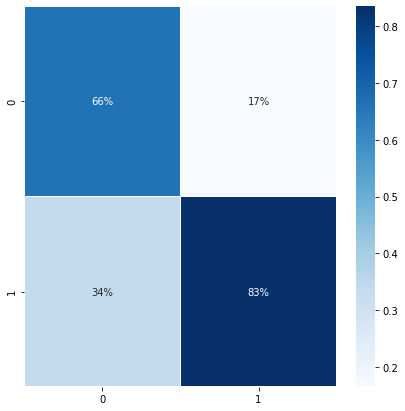

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = pd.DataFrame(confusion_matrix(y_true = y_test,
                                   y_pred = modelo.predict(X_test)),
                  index = [y_test[index] for index in 
                           np.unique(y_test, return_index = True)[1]], 
                  columns = [y_test[index] for index in 
                             np.unique(y_test, return_index = True)[1]])

##Tiene buena acertividad (suma de diagonal en la matriz de confusión)
display('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_test)))

fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(pd.DataFrame([cm[col]/cm[col].sum() for col in cm.columns]).transpose(), 
            annot = True,
            fmt = '.0%',
            cmap = 'Blues',
            linewidths = 0.5, 
            ax = ax)

<AxesSubplot:>

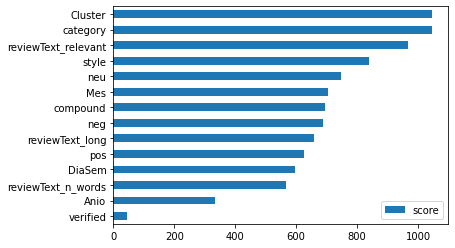

In [12]:
#Qué variables aportan más al modelo?
importance = modelo[1].best_estimator_.get_booster().get_score(importance_type='weight')

data = pd.DataFrame(data = list(importance.values()),
                    index = [(X.columns)[int(x[1:])] for x in importance.keys()], 
                    columns = ["score"]).sort_values(by = "score")
data.plot(kind='barh')

### Conservar modelo

In [13]:
#Exportar modelo
import pickle
with open('modelo_amazon_discreto.pkl', "wb") as f:
    pickle.dump(modelo, f)

In [14]:
#Importar modelo
import pickle    
with open('modelo_amazon_discreto.pkl', "rb") as f:
    modelo = pickle.load(f)

## Fin

In [15]:
#Tiempo total para correr el notebook
end = time.time()
time_exp(end - start)
tono()

7 minutos con 43.72 segundos
